In [10]:
!pip install -U datasets fsspec pyarrow


  Using cached fsspec-2025.5.1-py3-none-any.whl.metadata (11 kB)


# imports

In [11]:
import datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'DejaVu Sans'


# load datasets

In [12]:
ds = load_dataset("winvoker/turkish-sentiment-analysis-dataset")

In [13]:
print(ds)

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'dataset'],
        num_rows: 440679
    })
    test: Dataset({
        features: ['text', 'label', 'dataset'],
        num_rows: 48965
    })
})


In [14]:
print(ds['train'][0])

{'text': 'ürünü hepsiburadadan alalı 3 hafta oldu. orjinal ve eksiksiz şekilde geldi. şarj konusunda 1 günü rahat çıkarıyor oyun oynamama rağmen. teslimat sürecide hızlı gerçekleşti. en uygun fiyata iphone kalitesi kaçırmayın..', 'label': 'Positive', 'dataset': 'urun_yorumlari'}


# models

In [15]:
model_list = [
    "dbmdz/bert-base-turkish-cased",
    "savasy/bert-base-turkish-sentiment-cased"
]

labels = ["Negative", "Positive"]
model_results = {}


# metrics

In [16]:
def calc_metrics(eval_pred):
    logits, labels_ = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels_, predictions)
    f1 = f1_score(labels_, predictions, average='weighted')
    prec = precision_score(labels_, predictions, average='weighted')
    rec = recall_score(labels_, predictions, average='weighted')
    return {"accuracy": acc, "f1": f1, "precision": prec, "recall": rec}


# process df

In [17]:
def process_data(tokenizer, dataset):
    def tokenize_text(examples):
        return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=128)

    tokenized_dataset = dataset.map(tokenize_text, batched=True)
    filtered_data = tokenized_dataset.filter(lambda x: x['label'] in labels)
    filtered_data = filtered_data.cast_column("label", datasets.ClassLabel(num_classes=2, names=labels))
    filtered_data = filtered_data.rename_column("label", "labels")
    filtered_data.set_format("torch", columns=['input_ids', 'attention_mask', 'labels'])
    return filtered_data


In [18]:
for model_name in model_list:
    print(f"\nModel: {model_name} egitiliyor.")

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

    processed_data = process_data(tokenizer, ds)

    # training settings
    args = TrainingArguments(
        output_dir=f"./model_output_{model_name.split('/')[-1]}",
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=8,
        weight_decay=0.01,
        logging_steps=50,
        save_total_limit=2,
        load_best_model_at_end=True,
        metric_for_best_model="eval_f1",
        greater_is_better=True,
        warmup_steps=500,
        report_to="none",
        seed=42
    )

    early_stop = EarlyStoppingCallback(early_stopping_patience=3)

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=processed_data["train"],
        eval_dataset=processed_data["test"],
        tokenizer=tokenizer,
        compute_metrics=calc_metrics,
        callbacks=[early_stop]
    )

    # training
    trainer.train()

    test_results = trainer.evaluate()
    model_results[model_name] = {
        'accuracy': test_results['eval_accuracy'],
        'f1': test_results['eval_f1'],
        'precision': test_results['eval_precision'],
        'recall': test_results['eval_recall']
    }

    print(f"{model_name} bitti - F1: {test_results['eval_f1']:.4f}")



Model: dbmdz/bert-base-turkish-cased egitiliyor.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/48965 [00:00<?, ? examples/s]

Filter:   0%|          | 0/48965 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/31873 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.157700,0.126422,0.958899,0.958273,0.958208,0.958899
2,0.098800,0.154527,0.959433,0.958337,0.958957,0.959433
3,0.093500,0.159004,0.959025,0.959132,0.959256,0.959025
4,0.049400,0.209744,0.960437,0.960006,0.959866,0.960437
5,0.021700,0.262266,0.959558,0.959375,0.959242,0.959558
6,0.040200,0.275631,0.960123,0.959902,0.959757,0.960123
7,0.010500,0.301460,0.961127,0.960625,0.960531,0.961127
8,0.004300,0.317123,0.961315,0.960903,0.960770,0.961315


dbmdz/bert-base-turkish-cased bitti - F1: 0.9609

Model: savasy/bert-base-turkish-sentiment-cased egitiliyor.


tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/263k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

Map:   0%|          | 0/440679 [00:00<?, ? examples/s]

Map:   0%|          | 0/48965 [00:00<?, ? examples/s]

Filter:   0%|          | 0/440679 [00:00<?, ? examples/s]

Filter:   0%|          | 0/48965 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/286854 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/31873 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.164200,0.146472,0.955950,0.955508,0.955311,0.955950
2,0.111200,0.154314,0.959370,0.958528,0.958711,0.959370
3,0.091400,0.162625,0.959150,0.958828,0.958659,0.959150
4,0.058900,0.200241,0.959778,0.959448,0.959285,0.959778
5,0.035600,0.252980,0.959213,0.959102,0.959009,0.959213
6,0.020600,0.277887,0.959590,0.959393,0.959256,0.959590
7,0.009900,0.316623,0.960217,0.959702,0.959596,0.960217
8,0.003200,0.323980,0.959778,0.959377,0.959220,0.959778


savasy/bert-base-turkish-sentiment-cased bitti - F1: 0.9597


In [19]:
df_results = pd.DataFrame(model_results).T
print("\n" + "="*60)
print("MODEL KARSILASTIRMA SONUCLARI:")
print("="*60)
print(df_results.round(4))



MODEL KARSILASTIRMA SONUCLARI:
                                          accuracy      f1  precision  recall
dbmdz/bert-base-turkish-cased               0.9613  0.9609     0.9608  0.9613
savasy/bert-base-turkish-sentiment-cased    0.9602  0.9597     0.9596  0.9602


# Select best model

In [20]:
best_acc = df_results['accuracy'].idxmax()
best_f1 = df_results['f1'].idxmax()
print(f"\nEn yuksek accuracy: {best_acc} - {df_results.loc[best_acc, 'accuracy']:.4f}")
print(f"En yuksek f1: {best_f1} - {df_results.loc[best_f1, 'f1']:.4f}")



En yuksek accuracy: dbmdz/bert-base-turkish-cased - 0.9613
En yuksek f1: dbmdz/bert-base-turkish-cased - 0.9609


# Visualization

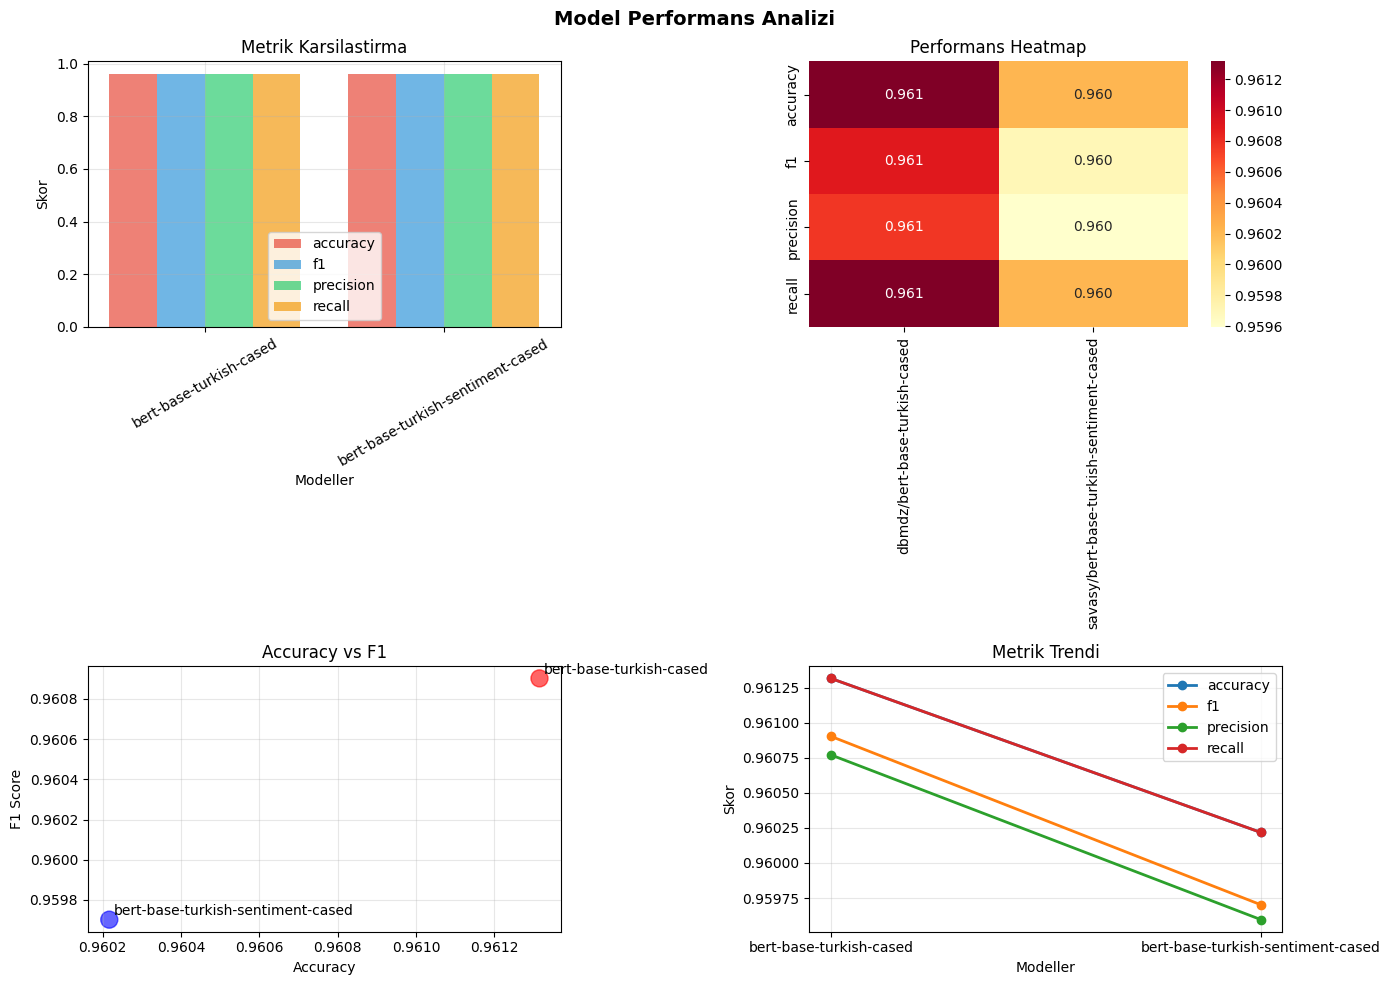

In [21]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Model Performans Analizi', fontsize=14, weight='bold')

# 1. bar
metrics = ['accuracy', 'f1', 'precision', 'recall']
x_positions = np.arange(len(df_results.index))
bar_width = 0.2

colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12']
for i, metric in enumerate(metrics):
    ax1.bar(x_positions + i*bar_width, df_results[metric], bar_width,
            label=metric, color=colors[i], alpha=0.7)

ax1.set_xlabel('Modeller')
ax1.set_ylabel('Skor')
ax1.set_title('Metrik Karsilastirma')
ax1.set_xticks(x_positions + bar_width * 1.5)
ax1.set_xticklabels([m.split('/')[-1] for m in df_results.index], rotation=30)
ax1.legend()
ax1.grid(alpha=0.3)

# 2. heatmap
sns.heatmap(df_results[metrics].T, annot=True, fmt='.3f', cmap='YlOrRd', ax=ax2)
ax2.set_title('Performans Heatmap')

# 3. scatter plot
ax3.scatter(df_results['accuracy'], df_results['f1'], s=150, c=['red', 'blue'], alpha=0.6)
for i, model in enumerate(df_results.index):
    ax3.annotate(model.split('/')[-1],
                (df_results.loc[model, 'accuracy'], df_results.loc[model, 'f1']),
                xytext=(3, 3), textcoords='offset points')
ax3.set_xlabel('Accuracy')
ax3.set_ylabel('F1 Score')
ax3.set_title('Accuracy vs F1')
ax3.grid(alpha=0.3)

# 4. line plot
model_names_short = [m.split('/')[-1] for m in df_results.index]
for metric in metrics:
    ax4.plot(model_names_short, df_results[metric], marker='o', label=metric, linewidth=2)
ax4.set_xlabel('Modeller')
ax4.set_ylabel('Skor')
ax4.set_title('Metrik Trendi')
ax4.legend()
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()



# csv

In [22]:
df_results.to_csv('model_comparison.csv')
print("\nSonuclar model_comparison.csv dosyasina kaydedildi.")



Sonuclar model_comparison.csv dosyasina kaydedildi.


# summary

In [23]:
print("\n" + "="*70)
print("VERI OZETI :")
print("="*70)
for model, results in model_results.items():
    print(f"\n{model}:")
    print(f"  Accuracy:  {results['accuracy']:.4f}")
    print(f"  F1 Score:  {results['f1']:.4f}")
    print(f"  Precision: {results['precision']:.4f}")
    print(f"  Recall:    {results['recall']:.4f}")


VERI OZETI :

dbmdz/bert-base-turkish-cased:
  Accuracy:  0.9613
  F1 Score:  0.9609
  Precision: 0.9608
  Recall:    0.9613

savasy/bert-base-turkish-sentiment-cased:
  Accuracy:  0.9602
  F1 Score:  0.9597
  Precision: 0.9596
  Recall:    0.9602
